# Historical Data Platform QA/QC Event Evaluation Procedure

| Event | Start Date | End Date | Location | Variables to Evaluate |
|-------|------------|----------|----------|-----------------------|
|Santa Ana Wind|2/16/1988|2/19/1988|Los Angeles, Orange, San Diego, San Bernadino, Riverside Counties|wind speed, wind direction, air temperature, humidity|
|Winter Storm | 12/20/1990|12/24/1990| WECC, Sac Valley, Oakland|air temperature, pressure, precipitation|
|AR|1/16/2017|1/20/2017|CA, coastal WECC|precipitation, wind speed, wind direction|
|Mudslide|1/5/2018|1/9/2018|Santa Barbara County|precipitation, wind speed, wind direction, air temperature|
|"Heatwave1"|8/14/2020|8/15/2020|WECC|air temperature, wind speed, air pressure|
|"Heatwave2"|9/5/2020|9/8/2020| CA (coastal + S. CA), Los Angeles County|air temperature, wind speed, air pressure|
|"Heatwave3"|8/30/2022|9/9/2020| CA (coastal + S. CA)|air temperature, wind speed, air pressure|
|Offshore wind|1/15/2021|1/16/2021|Coastal CA|wind speed, wind direction|

**In evaluation**: Santa Ana Wind

**Steps**:
1. Identify stations within event location
2. Retrieve station file to evaluate
3. Look at full timeseries plot (flagged_timeseries_plot) to see general trend
4. Look at climatology plot
5. Look at event plot

In [1]:
# import libraries
import xarray as xr
import numpy as np
import pandas as pd
import os
import sys

from qaqc_eval_utils import *

sys.path.append(os.path.expanduser('../'))
from QAQC_pipeline import qaqc_ds_to_df

%matplotlib inline
%load_ext autoreload
%autoreload 2

### Step 1: Retrieve relevant station files and comparison data for evaluation
Read in training list of QA/QC'd stations.

In [2]:
# read in stations
train_stns = pd.read_csv('../qaqc_training_station_list_events.csv')
train_stns.head()

,network,era-id,elevation,latitude,longitude,start_date,end_date,event_type,notes
0,ASOSAWOS,ASOSAWOS_72281023199,-14.0208,32.832,-115.664,1984-04-13 00:00:00+00:00,2022-12-31 00:00:00+00:00,all,NaN
1,ASOSAWOS,ASOSAWOS_72288023152,222.8088,34.200,-118.365,1943-06-01 00:00:00+00:00,2022-12-31 00:00:00+00:00,all,NaN
2,ASOSAWOS,ASOSAWOS_72288623130,239.2680,34.212,-118.491,1942-12-11 00:00:00+00:00,2022-12-31 00:00:00+00:00,all,NaN
3,ASOSAWOS,ASOSAWOS_72290023188,4.5720,32.734,-117.183,1942-01-01 00:00:00+00:00,2022-12-31 00:00:00+00:00,all,NaN
4,ASOSAWOS,ASOSAWOS_72290693112,4.2672,32.692,-117.210,1945-04-01 00:00:00+00:00,2022-12-31 00:00:00+00:00,all,NaN


In [3]:
# how to identify other events of interest using a start and end date
alt_start_date = "2007-10-20"
alt_end_date = "2007-10-24"
alt_event_stns = find_other_events(train_stns, event_start=alt_start_date, event_end=alt_end_date, buffer=14, subset=5)
alt_event_stns

Subsetting station record for event duration with 14 day buffer...
5 stations selected for evaluation for comparison!
Stations selected for evaluation:
 ['ASOSAWOS_72688304113', 'CRN_ISWC1', 'CWOP_C3424', 'CWOP_C7477', 'RAWS_TS730']


,network,era-id,elevation,latitude,longitude,start_date,end_date,event_type,notes
236,ASOSAWOS,ASOSAWOS_72688304113,195.072,45.82600,-119.26100,2006-01-01 00:00:00+00:00,2022-12-31 00:00:00+00:00,"AR, mudslide, aug2020_heatwave, sep2020_heatwa...",NaN
319,CRN,CRN_ISWC1,80.000,36.60194,-117.14500,2006-12-16 00:00:00+00:00,2023-03-06 21:10:00+00:00,"AR, mudslide, aug2020_heatwave, sep2020_heatwa...",NaN
757,CWOP,CWOP_C3424,5001.000,-111.30133,34.23367,2005-03-02 00:00:00+00:00,2014-04-04 22:14:00+00:00,NaN,NaN
766,CWOP,CWOP_C7477,7002.000,-117.38917,45.39917,2007-02-07 00:00:00+00:00,2015-12-13 01:18:00+00:00,NaN,NaN
573,RAWS,RAWS_TS730,7021.000,33.23028,-106.70745,2007-10-06 00:00:00+00:00,2022-06-02 17:52:00+00:00,"AR, mudslide, aug2020_heatwave, sep2020_heatwa...",NaN


For event evaluation, randomly sample for a manageable number of stations per event using the `subset_eval_stns` function.

In [4]:
eval_stations = subset_eval_stns(
    event_to_eval = 'santa_ana_wind',
    stn_list = train_stns,
    subset = 5,
    return_stn_ids = True
)
eval_stations

17 potential stations available for evaluation for santa_ana_wind event.
5 stations selected for evaluation for santa_ana_wind event!
Stations selected for evaluation:
 ['ASOSAWOS_72381603159', 'ASOSAWOS_74718703104', 'ASOSAWOS_72383023187', 'ASOSAWOS_72290993115', 'OtherISD_72286023119']


,network,era-id,elevation,latitude,longitude,start_date,end_date,event_type,notes,STATEFP,...,CBSAFP,METDIVFP,FUNCSTAT,ALAND,AWATER,INTPTLAT,INTPTLON,Shape_Leng,Shape_Area,geometry
5,ASOSAWOS,ASOSAWOS_72381603159,712.6224,34.741,-118.213,1974-06-01 00:00:00+00:00,2022-12-31 00:00:00+00:00,all,NaN,06,...,31080,31084,A,1.051186e+10,1.793485e+09,+34.1963983,-118.2618616,883876.944789,1.803431e+10,POINT (-13159410.965 4128739.545)
13,ASOSAWOS,ASOSAWOS_74718703104,-35.9664,33.632,-116.164,1943-07-12 00:00:00+00:00,2022-12-31 00:00:00+00:00,all,NaN,06,...,40140,NaN,A,1.867121e+10,2.438832e+08,+33.7298275,-116.0022389,911208.750606,2.742705e+10,POINT (-12931317.329 3979495.007)
7,ASOSAWOS,ASOSAWOS_72383023187,1374.6480,34.744,-118.725,1973-01-01 00:00:00+00:00,2022-12-31 00:00:00+00:00,all,NaN,06,...,31080,31084,A,1.051186e+10,1.793485e+09,+34.1963983,-118.2618616,883876.944789,1.803431e+10,POINT (-13216406.544 4129145.958)
10,ASOSAWOS,ASOSAWOS_72290993115,7.3152,32.568,-117.117,1973-01-01 00:00:00+00:00,2022-12-31 00:00:00+00:00,all,NaN,06,...,41740,NaN,A,1.090437e+10,8.174046e+08,+33.0236041,-116.7761174,553042.602989,1.672201e+10,POINT (-13037404.803 3838102.574)
15,OtherISD,OtherISD_72286023119,468.2000,33.900,-117.250,1933-01-01 00:00:00+00:00,2023-03-14 00:00:00+00:00,all,NaN,06,...,40140,NaN,A,1.867121e+10,2.438832e+08,+33.7298275,-116.0022389,911208.750606,2.742705e+10,POINT (-13052210.296 4015382.360)


Visualize the station next

(<Figure size 640x480 with 1 Axes>,
 <GeoAxesSubplot:title={'center':'santa_ana_wind evaluation \nat OtherISD_72286023119'}>)

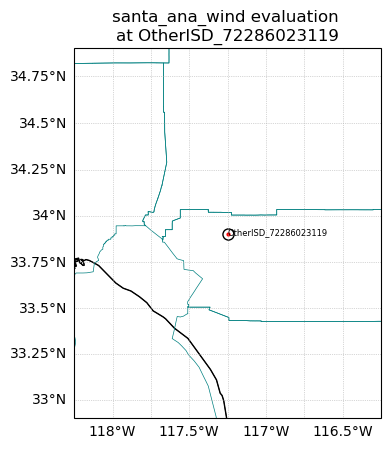

In [6]:
stn_visualize(
    stn_id = eval_stations['era-id'].values[-1],
    stn_list = eval_stations,
    event_to_eval = 'santa_ana_wind'
)

### Step 2: Holistic / qualitative station evaluation
Identify flags set during the entire timeseries for the designated station

In [6]:
# pull station from AWS
# ds = pull_nc_from_aws(eval_stations['era-id'].values[-1]) # retrieve from list 
ds = pull_nc_from_aws('CIMIS_45') # manually retrieve a specific station
ds

Retrieving data for station...


<xarray.Dataset>
Dimensions:               (station: 1, time: 26304)
Coordinates:
  * station               (station) object 'CIMIS_45'
  * time                  (time) datetime64[ns] 1986-01-01T09:00:00 ... 1989-...
Data variables: (12/30)
    tas                   (station, time) float64 ...
    pr                    (station, time) float64 ...
    hurs                  (station, time) float64 ...
    rsds                  (station, time) float64 ...
    sfcWind               (station, time) float64 ...
    sfcWind_dir           (station, time) float64 ...
    ...                    ...
    sfcWind_dir_eraqc     (station, time) float64 ...
    elevation_eraqc       (station, time) float64 ...
    tdps_derived_eraqc    (station, time) int64 ...
    pvp_derived_eraqc     (station, time) float64 ...
    anemometer_height_m   (station, time) float64 ...
    thermometer_height_m  (station, time) float64 ...
Attributes: (12/16)
    title:                 CIMIS quality controlled
    institution:           Eagle Rock Analytics / Cal Adapt
    source:                
    history:               CIMIS_clean.py script run on 02-13-2023, 22:25:54 ...
    comment:               Intermediate data product: may not have been subje...
    license:               
    ...                    ...
    wind_vane_height_m:    2.0
    anemometer_height_m:   2.0
    thermometer_height_m:  1.5
    humidity_height_m:     1.5
    rain_gauge_height_m:   1.0
    raw_files_merged:      3

In [8]:
ds_sub = ds.sel(time=slice('1987', '1987'))
ds_sub

<xarray.Dataset>
Dimensions:               (station: 1, time: 8760)
Coordinates:
  * station               (station) object 'CIMIS_45'
  * time                  (time) datetime64[ns] 1987-01-01 ... 1987-12-31T23:...
Data variables: (12/30)
    tas                   (station, time) float64 289.6 288.0 ... 289.9 288.9
    pr                    (station, time) float64 0.0 0.0 0.0 ... 0.0 0.0 0.0
    hurs                  (station, time) float64 55.0 76.0 80.0 ... 31.0 31.0
    rsds                  (station, time) float64 140.0 21.0 2.0 ... 443.0 337.0
    sfcWind               (station, time) float64 3.6 2.3 1.0 ... 1.4 2.1 3.0
    sfcWind_dir           (station, time) float64 270.7 293.8 ... 246.2 264.5
    ...                    ...
    sfcWind_dir_eraqc     (station, time) float64 nan nan nan ... nan nan nan
    elevation_eraqc       (station, time) float64 nan nan nan ... nan nan nan
    tdps_derived_eraqc    (station, time) int64 19 19 19 19 19 ... 19 19 19 19
    pvp_derived_eraqc     (station, time) float64 nan nan nan ... nan nan nan
    anemometer_height_m   (station, time) float64 2.0 2.0 2.0 ... 2.0 2.0 2.0
    thermometer_height_m  (station, time) float64 1.5 1.5 1.5 ... 1.5 1.5 1.5
Attributes: (12/16)
    title:                 CIMIS quality controlled
    institution:           Eagle Rock Analytics / Cal Adapt
    source:                
    history:               CIMIS_clean.py script run on 02-13-2023, 22:25:54 ...
    comment:               Intermediate data product: may not have been subje...
    license:               
    ...                    ...
    wind_vane_height_m:    2.0
    anemometer_height_m:   2.0
    thermometer_height_m:  1.5
    humidity_height_m:     1.5
    rain_gauge_height_m:   1.0
    raw_files_merged:      3

In [7]:
%%time 
df, MultiIndex, attrs, var_attrs, era_qc_vars = qaqc_ds_to_df(ds)

Filling anemometer_height_m with NaN.
Filling thermometer_height_m with NaN.
CPU times: user 134 ms, sys: 12 ms, total: 146 ms
Wall time: 144 ms


In [8]:
# santa ana wind vars: air temp, humidity, wind speed, wind direction
vars_to_check = ['tas', 'hurs', 'sfcWind', 'sfcWind_dir']
vars_to_eval = [var for var in vars_to_check if var in df.columns] # check if variable is not present in the specific station

for var in vars_to_eval:
    known_issue_check(network=df.station.unique()[0].split('_')[0], 
                      var=var, 
                      stn=df.station.unique()[0]) # check if known issues are present first!
    print('Evaluating: {}'.format(var))
    flagged_timeseries_plot(df, var=var)

Checking for known station issues...
Evaluating: tas
Checking for known station issues...
Evaluating: hurs
Checking for known station issues...
Evaluating: sfcWind
Checking for known station issues...
Evaluating: sfcWind_dir


Identify flags set during event for evaluation

In [9]:
subset_df = event_subset(df, event='santa_ana_wind', buffer=14)

Subsetting station record for event duration with 14 day buffer...


In [10]:
# identify flags set for initial pass
for v in vars_to_eval:
    f = flags_during_event(subset_df, var=v, event='santa_ana_wind')

Flags set on tas during santa_ana_wind event: [nan]
Flags set on hurs during santa_ana_wind event: [nan]
Flags set on sfcWind during santa_ana_wind event: [nan]
Flags set on sfcWind_dir during santa_ana_wind event: [nan]


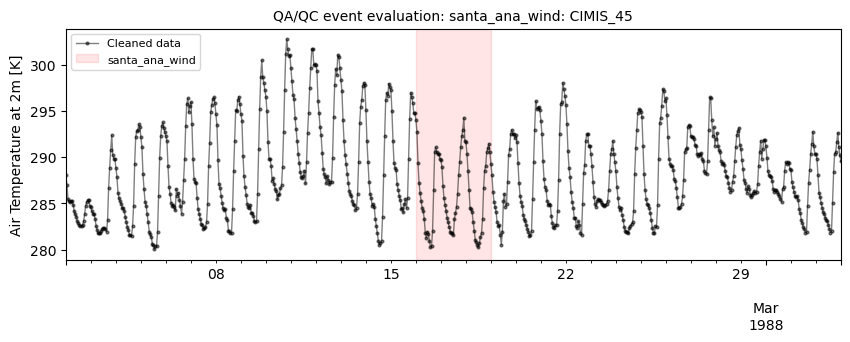

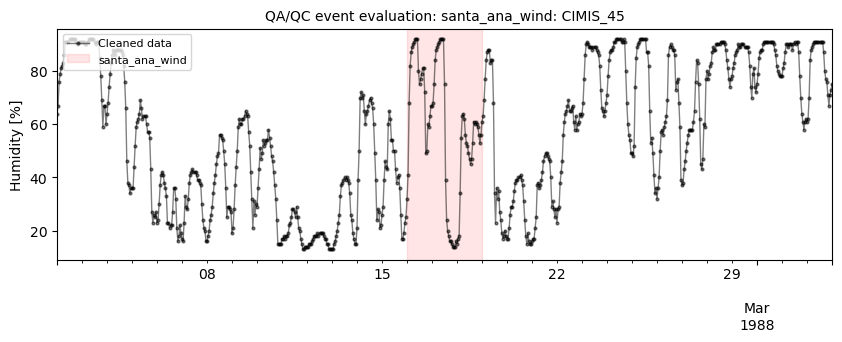

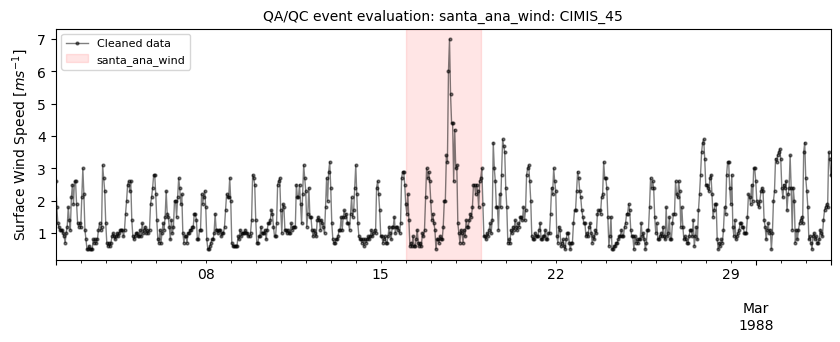

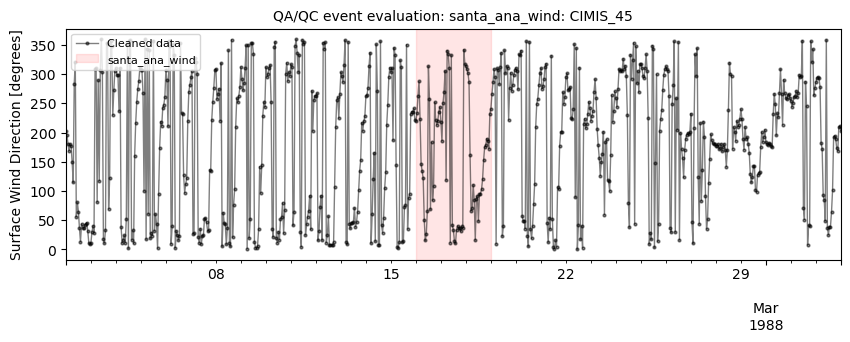

In [11]:
for var in vars_to_eval:
    event_plot(subset_df, var=var, event='santa_ana_wind')

### Optional multi-station run and identification of flags

In [ ]:
# official event stations
stns_to_run = list(eval_stations['era-id'])
multi_stn_check(stns_to_run, event='santa_ana_wind')

Evaluation on ASOSAWOS_72389093193...
Retrieving data for station...
Converting to dataframe...
Filling anemometer_height_m with NaN.
Filling thermometer_height_m with NaN.
Checking for known station issues...
Evaluating: tas
Checking for known station issues...
Evaluating: sfcWind
Checking for known station issues...
Evaluating: sfcWind_dir
Subsetting station record for event duration with 7 day buffer...
Flags set on tas during alternative event: [nan]
Flags set on sfcWind during alternative event: [nan]
Flags set on sfcWind_dir during alternative event: [nan]
Evaluation on RAWS_TR118...
Retrieving data for station...
Converting to dataframe...
Filling anemometer_height_m with NaN.
Filling thermometer_height_m with NaN.
Checking for known station issues...
Known network issue for RAWS tas: values may be too high (on order of 10°F) if sun is shining strongly and winds are light.
Evaluating: tas
Checking for known station issues...
Evaluating: hurs
Checking for known station issues...


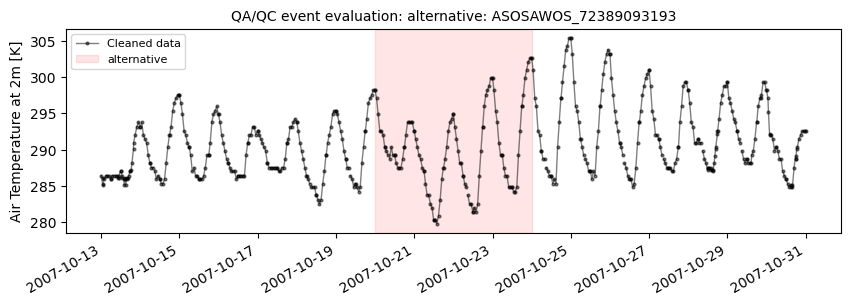

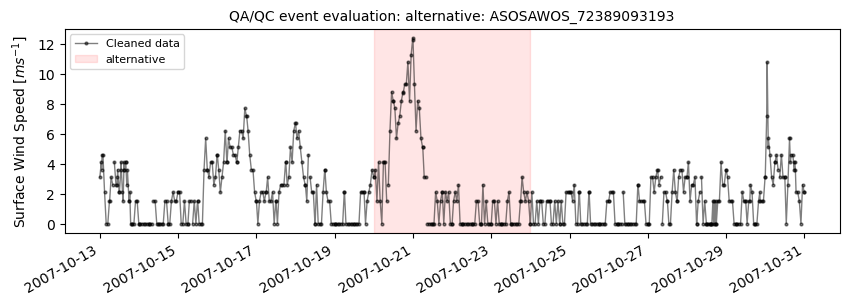

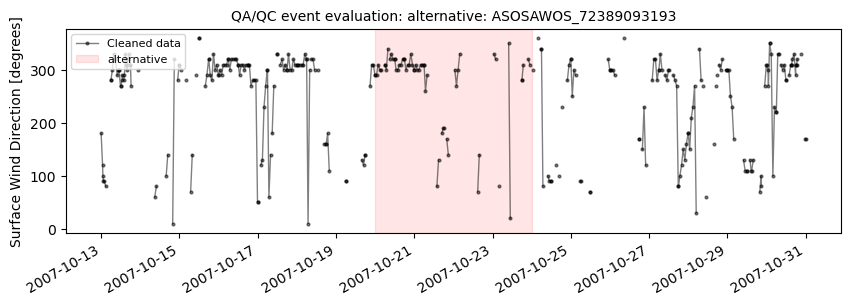

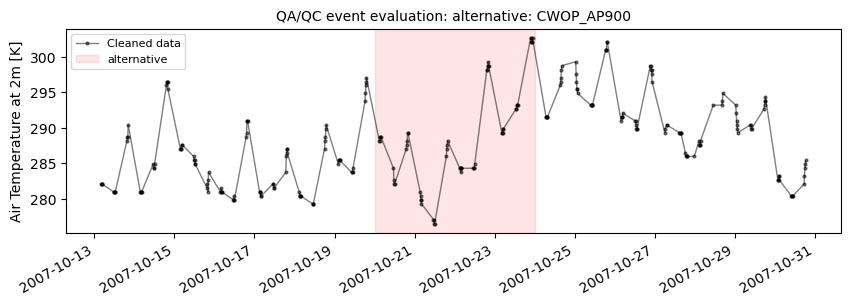

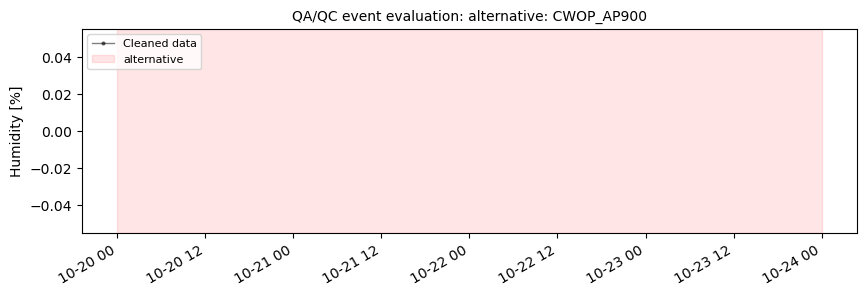

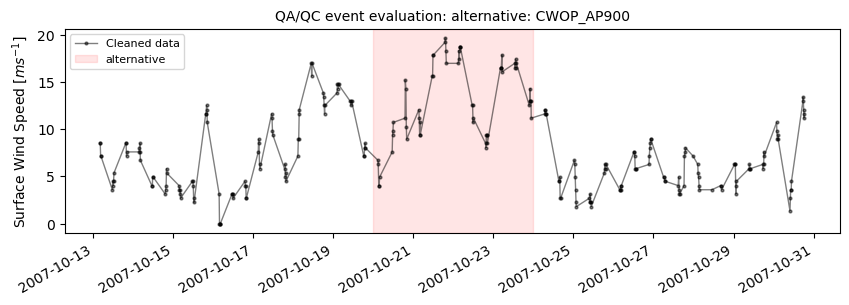

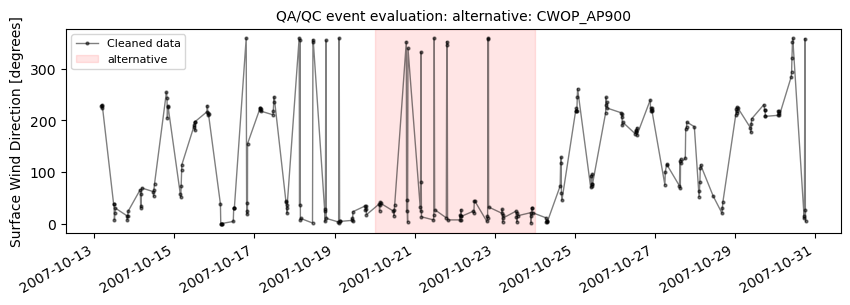

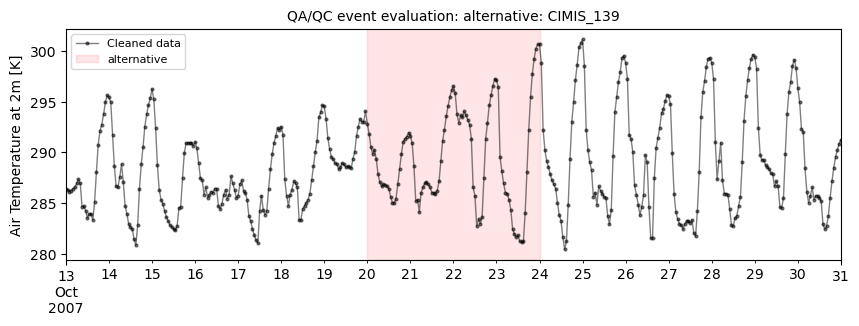

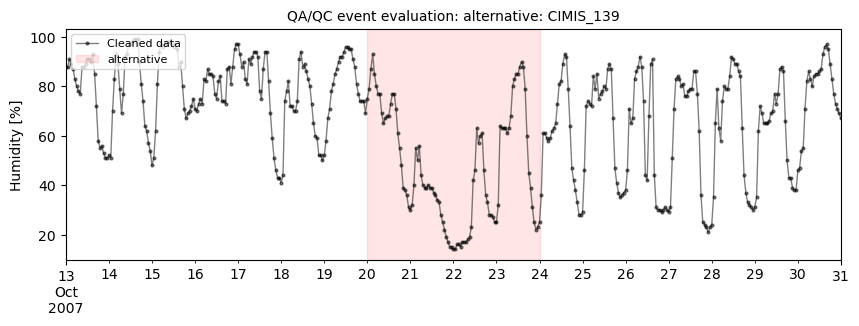

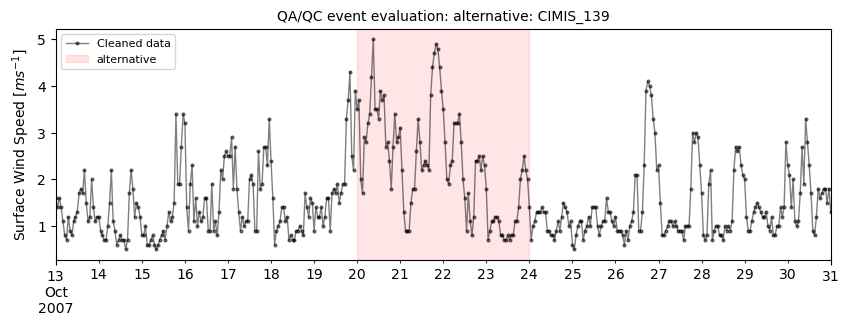

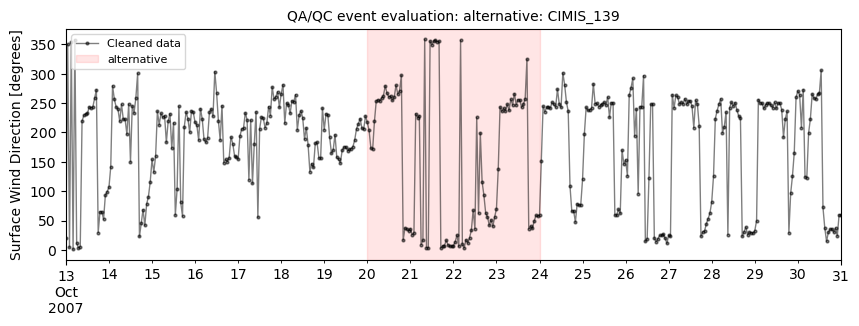

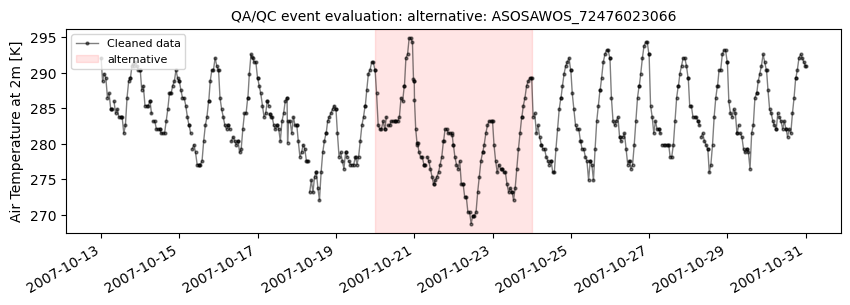

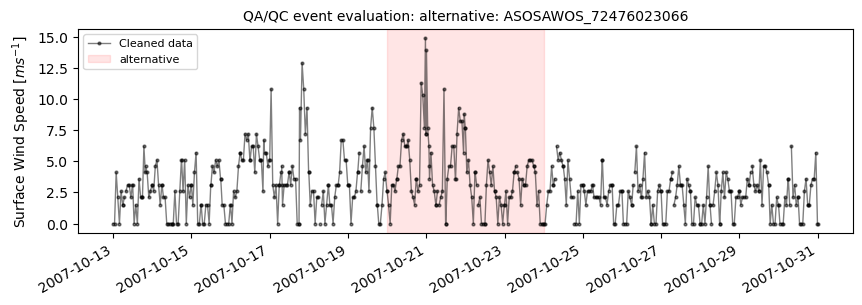

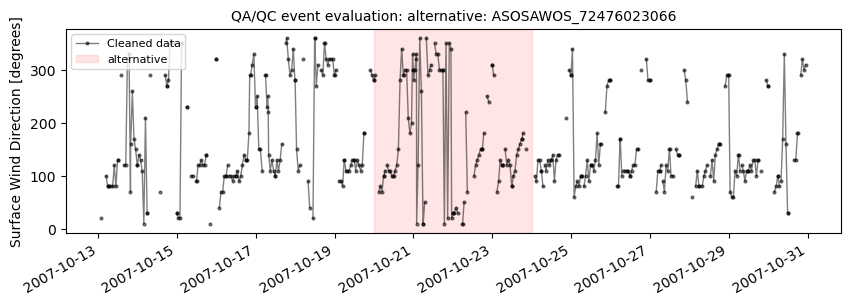

In [13]:
# alternative event stations
stns_to_run = list(alt_event_stns['era-id'])
multi_stn_check(stns_to_run, event='alternative', alt_start_date=alt_start_date, alt_end_date=alt_end_date)

In [ ]:
fig, ax = plt.subplots(subplot_kw={'projection':ccrs.epsg(3857)})
ax.coastlines()
eval_stations.plot(ax=ax, markersize=8)

# ax.plot(lon, lat, 'ok', markersize=8, transform=ccrs.PlateCarree(), mfc='none')
# ax.plot(x, y, '.r', markersize=4)

---
#### Append local GHCNh library path

In [ ]:
ghcnh_lib_path = "/Users/hector/ERA_work/historical-obs-platform/test_platform/scripts/3_qaqc_data/qaqc_eval_notebooks/GHCNh"
sys.path.append(ghcnh_lib_path)
# from GHCNh.GHCNh_lib import GHCNh  # If GHCNh is within current folder
from GHCNh_lib import GHCNh # If GHCNh is was appended to path

In [ ]:
%%time
ghcnh = GHCNh(stations_local=True)
ghcnh.select_wecc()
id = ghcnh.stations_df['id'].iloc[0]
ghcnh.read_data_from_url(id, save=True)
ghcnh.convert_df_to_gpd()
ghcnh.station_data.head(3)

In [ ]:
lon = ghcnh.station_data.Longitude.mean()
lat = ghcnh.station_data.Latitude.mean()
print("{}, {:.5f}, {:.5f}".format(id, lon, lat))

In [ ]:
fig,ax = plt.subplots(figsize=(9,3))

ghcnh.station_data.plot(ax=ax, x="time", y="temperature")
ghcnh.station_data.plot(ax=ax, x="time", y="dew_point_temperature")
ax.set_title("{}  ({:.3f}, {:.3f})".format(id,lon,lat));

In [ ]:
# initial test for identifying the event: large jumps on windspeed

In [ ]:
return_ghcn_vars(ghcnh.station_data, 'sfcWind').head(3)